<a href="https://colab.research.google.com/github/907Resident/caldera-gas-emissions/blob/logistic-prediction/forecast_sat_concentration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Saturation Concentration
In this exercise, the gas measurements made at the various locations around Yellowstone and Valles Caldera are examined as time series. From there, I apply a logistic regression to forecast the concentration (and the time) the measurements would have yielded in the field.


## Import Necessary Libraries

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import io

from datetime import datetime
# Import fbprphet for forecasting
from fbprophet import Prophet

## Ingest data into workspace
The ultimate goal is to utilze the Microsoft's `onedrivesdk` package to acces data straight from OneDrive using their [Graph API](https://docs.microsoft.com/en-us/graph/api/overview?view=graph-rest-1.0). This is currently issue #1 in the repo. 

For the time being, data is ingested manually using `files` from the `google.colab` library.

In [ ]:
# Manual File Upload from local drive
from google.colab import files
uploaded = files.upload()

Saving YNP_SummaryData.xlsx to YNP_SummaryData.xlsx


In [ ]:
# Import file into workspace
import io
df_2019_YC = pd.read_excel(io.BytesIO(uploaded['YNP_SummaryData.xlsx']), 
                           sheet_name="2019",
                           header=0)
# Delete first row that contains secondary data information
df_2019_YC.drop([0], inplace=True)

# Reset index
df_2019_YC.reset_index(drop=True, inplace=True)

# Preview data
df_2019_YC.head(10)

,Site_Name,Group,Location,Soil_Classification,Latitude,Longitude,Date_of_Measurement,Start_Time_of_Chamber_Enclosure,End_Time_of_Chamber_Enclosure,Duration_of_Chamber_Enclosure,CH4_Flux,Long_Term_CH4_Flux,d13CH4_source,LowerBound_d13CH4_source,UpperBound_d13CH4_source,CO2_Flux,Long_Term_CO2_Flux,d13CO2_source,LowerBound_d13CO2_source,UpperBound_d13CO2_source,Horita_Geothermometer_Temperature_at_Formation,Ambient_Temperature,Barometric_Pressure,Soil_Moisture,Soil_Conductivity,Soil_Tempeature_at_Surface,Soil_Tempeature_at_6_in_depth
0,Gas Vents,Gas Vents (Solfatara Springs),GVNT_06Jun2019_3.1,Acid-Sulphate,44.7095,-110.554,2019-06-06 00:00:00,2019-06-06 11:15:48,2019-06-06 11:33:27,17.65,-0.0142029,-0.124503,-60.1871,-94.4202,-25.954,61.6027,0.540009,-0.994721,-0.994721,4.3392,NaN,NaN,NaN,NaN,NaN,10.8,NaN
1,Gas Vents,Gas Vents (Solfatara Springs),GVNT_06Jun2019_3.2,Acid-Sulphate,44.7097,-110.554,2019-06-06 00:00:00,2019-06-06 11:49:57,2019-06-06 12:04:49,14.8667,0.245512,2.15215,-11.7023,-14.3093,-9.09528,1998.61,17.5198,-4.19908,-4.19908,-4.04135,NaN,NaN,NaN,NaN,NaN,19,NaN
2,Gas Vents,Gas Vents (Solfatara Springs),GVNT_06Jun2019_3.3,Acid-Sulphate,44.7098,-110.554,2019-06-06 00:00:00,2019-06-06 12:26:56,2019-06-06 12:35:29,8.55,1.92642,16.887,-30.8819,-31.8585,-29.9052,3759.53,32.956,-6.3691,-6.3691,-6.1339,NaN,NaN,NaN,NaN,NaN,20.7,NaN
3,Gas Vents,Gas Vents (Solfatara Springs),GVNT_06Jun2019_4.1,Acid-Sulphate,44.7112,-110.554,2019-06-06 00:00:00,2019-06-06 13:59:30,2019-06-06 14:01:43,2.21667,9.77365,85.6758,-26.7443,-28.5211,-24.9675,15562.5,136.421,-9.25684,-9.25684,-3.47258,NaN,NaN,NaN,NaN,NaN,43.3,NaN
4,Gas Vents,Gas Vents (Solfatara Springs),GVNT_06Jun2019_4.2,Acid-Sulphate,44.7113,-110.554,2019-06-06 00:00:00,2019-06-06 14:27:20,2019-06-06 14:33:03,5.71667,4.06264,35.6131,-30.2581,-30.9619,-29.5543,5666.13,49.6693,4.18146,4.18146,7.97036,NaN,NaN,NaN,NaN,NaN,46.5,NaN
5,Gas Vents,Gas Vents (Solfatara Springs),GVNT_06Jun2019_4.3,Acid-Sulphate,44.7114,-110.554,2019-06-06 00:00:00,2019-06-06 14:57:48,2019-06-06 15:12:35,14.7833,0.0168218,0.14746,15.2084,-18.3973,48.8141,412.968,3.62008,-0.51335,-0.51335,0.32896,NaN,NaN,NaN,NaN,NaN,35.4,NaN
6,Gas Vents,Gas Vents (Solfatara Springs),GVNT_06Jun2019_4.4,Acid-Sulphate,44.7115,-110.554,2019-06-06 00:00:00,2019-06-06 15:44:02,2019-06-06 15:59:12,15.1667,0.0367235,0.321918,-15.1822,-33.143,2.77863,133.321,1.16869,50.5918,50.5918,59.2262,NaN,NaN,NaN,NaN,NaN,28.6,NaN
7,West Thumb,West Thumb GB,WTHB_07Jun2019_3.1,Neutral-Chloride,44.4166,-110.572,2019-06-07 00:00:00,2019-06-07 10:54:00,2019-06-07 11:09:42,15.7,0.0022978,0.0201425,53.72,-63.6822,171.122,-24.9418,-0.21864,-16.926,0,-14.3105,NaN,NaN,NaN,NaN,NaN,19.5,NaN
8,West Thumb,West Thumb GB,WTHB_07Jun2019_3.2,Neutral-Chloride,44.4182,-110.572,2019-06-07 00:00:00,2019-06-07 11:45:32,2019-06-07 12:00:58,15.4333,0.0290361,0.254531,-57.6858,-75.1049,-40.2666,34.4015,0.301564,4.06232,0,6.21635,NaN,NaN,NaN,NaN,NaN,18,NaN
9,West Thumb,West Thumb GB,WTHB_07Jun2019_3.3,Neutral-Chloride,44.4183,-110.572,2019-06-07 00:00:00,2019-06-07 12:27:19,2019-06-07 12:43:48,16.4833,0.00677303,0.0593724,-28.279,-82.5482,25.9902,13.0644,0.114522,-22.2025,0,-17.6532,NaN,NaN,NaN,NaN,NaN,18.6,NaN


In addition to mannually importing a .xlsx file, we will need to import a .mat file (produced in MATLAB). This file will contain several items that will be stored in a dictionary. Use the `loadmat` function from the `scipy.io` package  to extract the .mat file. More details are [here](https://stackoverflow.com/questions/45007081/convert-mat-file-to-pandas-dataframe).

In [2]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Point directory towards the correct folder
%cd /content/gdrive/My Drive/Colab Notebooks/caldera-gases

/content/gdrive/My Drive/Colab Notebooks/caldera-gases


In [4]:
# Import the scipy.io package
import h5py
# Gather the .mat file
dict_GVNT_06Jun2019 = h5py.File("pertinent-data/GVNT_06Jun2019_MATFILE.mat",
                                "r")
# Print the list of items in the .mat file
list(dict_GVNT_06Jun2019.keys())


['#refs#',
 '#subsystem#',
 'GVNT_ChamON',
 'GVNT_ChamON_DateTimes',
 'GVNT_PostBack',
 'GVNT_PostBack_DateTimes',
 'GVNT_PreBack',
 'GVNT_PreBack_DateTimes',
 'lin_flux',
 'lin_mdl',
 'lin_slope']

In [10]:
# Convert the first chamber enclosure to a dataframe and be sure to transpose it
# to the correct dimensions
df = pd.DataFrame(dict_GVNT_06Jun2019['GVNT_ChamON'][2]).T

In [11]:
# Add column names with list
col_names = ["date", "elapsed_sec", "CH4_dry", "CH4", "d13_CH4", "d13_CH4_HR",
             "CO2_dry", "d13_CO2", "alarm", "CH4_cgs", "CO2_cgs"]
# Substitute in the new column names             
df.columns = col_names
# Change the date column to the correct timestamps
df["date"] = pd.to_datetime(df["date"]-719529, unit='D')
# Preview dataset
df.head()

,date,elapsed_sec,CH4_dry,CH4,d13_CH4,d13_CH4_HR,CO2_dry,d13_CO2,alarm,CH4_cgs,CO2_cgs
0,2019-06-06 12:26:56.000025600,0.000,1.849656,1.877614,-44.060339,-44.060339,421.737046,-10.220448,0.0,1.086377,679.496772
1,2019-06-06 12:27:00.000000000,3.491,1.851102,1.879069,-48.032279,-48.032279,421.777091,-10.243013,0.0,1.087226,679.561291
2,2019-06-06 12:27:02.999980800,6.994,1.853991,1.882063,-48.611680,-48.611680,422.768287,-9.812516,0.0,1.088924,681.158293
3,2019-06-06 12:27:06.999955200,10.473,1.858189,1.886456,-47.180816,-47.180816,424.967150,-9.323391,0.0,1.091389,684.701071
4,2019-06-06 12:27:10.000022400,13.951,1.865596,1.894218,-46.435142,-46.435142,428.332146,-9.808875,0.0,1.095739,690.122705


## Incorporate Logistic Modeling

In [12]:
df_test = df[["date", "CH4_dry"]]
df_test.dropna(inplace=True)
df_test.set_index("date", inplace=True)
df_test.index = df_test.index.rename("ds")
df_test.index = df_test.index.round("S")
names_Prophet_df = ["y"]
df_test.columns = names_Prophet_df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [13]:
df_test.reset_index(inplace=True)
print(df_test)

                     ds         y
0   2019-06-06 12:26:56  1.849656
1   2019-06-06 12:27:00  1.851102
2   2019-06-06 12:27:03  1.853991
3   2019-06-06 12:27:07  1.858189
4   2019-06-06 12:27:10  1.865596
..                  ...       ...
142 2019-06-06 12:35:15  4.720467
143 2019-06-06 12:35:18  4.735887
144 2019-06-06 12:35:22  4.751378
145 2019-06-06 12:35:25  4.767941
146 2019-06-06 12:35:29  4.783116

[147 rows x 2 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


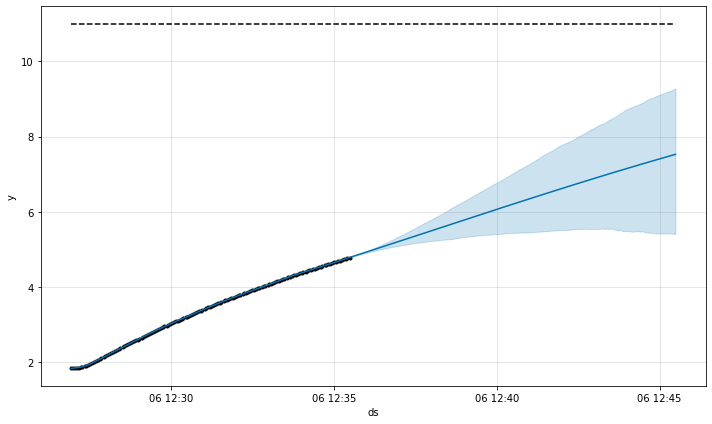

In [42]:
df_test["cap"] = 11
m = Prophet(growth='logistic')
m.fit(df_test)

# Python
future = m.make_future_dataframe(periods=600, freq="S")
future['cap'] = 11
fcst = m.predict(future)
fig = m.plot(fcst)

In [38]:
fcst[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'trend_lower', 'trend_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
742,2019-06-06 12:45:25,7.525258,5.869597,9.087022,7.525258,5.868875,9.087526
743,2019-06-06 12:45:26,7.529852,5.867108,9.091355,7.529852,5.867105,9.090712
744,2019-06-06 12:45:27,7.534445,5.865454,9.094828,7.534445,5.865630,9.095935
745,2019-06-06 12:45:28,7.539039,5.868233,9.104108,7.539039,5.865746,9.105300
746,2019-06-06 12:45:29,7.543632,5.867306,9.117160,7.543632,5.865862,9.114707
